In [30]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data

In [2]:
boston = load_boston()
print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

# Process Data

In [3]:
df_boston = pd.DataFrame(boston['data'], columns=boston['feature_names'])
df_boston['MEDV'] = boston['target'] # target median value of home in $1000's

# Feature engineering: Convert average number of rooms per dwelling to int
df_boston['num_rooms'] = df_boston['RM'].apply(lambda x: int(x)) 

print(f'Dataset size: {df_boston.shape}')
df_boston.head()

Dataset size: (506, 15)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,num_rooms
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,6
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,6
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,7


In [4]:
# Split dataframe into train and test
df_train, df_test = train_test_split(df_boston, test_size=0.2, random_state=42)
df_train = df_train.reset_index()
df_test = df_test.reset_index()
print(f'Size of train set: {df_train.shape}')
print(f'Size of test set: {df_test.shape}')

Size of train set: (404, 16)
Size of test set: (102, 16)


In [5]:
# Distribution of train
df_train.describe()

,index,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,num_rooms
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,250.428218,3.584372,11.569307,10.985050,0.071782,0.556484,6.315891,68.556436,3.808195,9.356436,404.032178,18.318317,356.278342,12.457351,22.796535,5.804455
std,142.332893,8.869255,23.152481,6.894618,0.258447,0.117704,0.709452,27.994922,2.131226,8.589721,166.172655,2.228701,91.566533,7.110381,9.332147,0.790062
min,1.000000,0.009060,0.000000,0.740000,0.000000,0.385000,3.863000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000,3.000000
25%,132.250000,0.081437,0.000000,5.130000,0.000000,0.452000,5.890500,45.550000,2.087875,4.000000,279.000000,16.800000,375.472500,6.772500,16.950000,5.000000
50%,249.500000,0.261390,0.000000,8.560000,0.000000,0.538000,6.210000,77.700000,3.175750,5.000000,330.000000,18.700000,391.305000,10.925000,21.600000,6.000000
75%,369.250000,2.983900,20.000000,18.100000,0.000000,0.631000,6.636750,93.650000,5.400800,12.000000,666.000000,20.200000,395.755000,16.372500,26.400000,6.000000
max,505.000000,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000,8.000000


In [6]:
# Distribution of test
df_test.describe()

,index,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,num_rooms
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,260.705882,3.630947,10.549020,11.737745,0.058824,0.547609,6.160833,68.648039,3.742949,10.313725,424.892157,18.999020,358.241275,13.428235,21.488235,5.666667
std,161.162337,7.459607,24.083242,6.722576,0.236456,0.108602,0.663825,28.890866,2.010749,9.161889,177.462472,1.800577,90.641872,7.244601,8.605804,0.722116
min,0.000000,0.006320,0.000000,0.460000,0.000000,0.392000,3.561000,6.200000,1.169100,1.000000,188.000000,13.000000,6.680000,2.880000,5.000000,3.000000
25%,90.750000,0.087368,0.000000,6.102500,0.000000,0.448250,5.870250,43.800000,2.263950,4.000000,281.750000,18.400000,375.020000,7.687500,17.125000,5.000000
50%,272.500000,0.209885,0.000000,10.590000,0.000000,0.532000,6.170500,74.700000,3.353400,5.000000,345.000000,19.200000,392.205000,12.335000,20.150000,6.000000
75%,410.250000,4.522473,0.000000,18.100000,0.000000,0.621500,6.479250,95.225000,4.764825,24.000000,666.000000,20.200000,396.900000,18.017500,24.075000,6.000000
max,501.000000,45.746100,95.000000,27.740000,1.000000,0.871000,8.034000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,36.980000,50.000000,8.000000


# Baseline Models

1. Use overall mean value of all houses in the train set
2. Use mean value based on number of rooms in the train set

In [7]:
print('Overall mean value: $%.2f' % (df_train['MEDV'].mean() * 1000))

Overall mean value: $22796.53


In [8]:
# Get mean value based on number of rooms (and make sure there are enough samples)
df_num_rooms = df_train.groupby('num_rooms').agg({'MEDV': ['mean', 'count']}).reset_index()
df_num_rooms.columns = [' '.join(col).strip() for col in df_num_rooms.columns.values]
df_num_rooms

,num_rooms,MEDV mean,MEDV count
0,3,23.100000,1
1,4,17.320000,10
2,5,17.654400,125
3,6,21.926066,211
4,7,36.793333,45
5,8,43.716667,12


Since there's only one sample for 3 bedroom dwellings, we'll fall back to the overall mean in this case.

In [10]:
# Store mean value by number of rooms in a dictionary
num_rooms_value_dict = {}
for _, row in tqdm(df_num_rooms.iterrows()):
    if row['num_rooms'] == 3: # fall back to overall mean
        num_rooms_value_dict[row['num_rooms']] = df_train['MEDV'].mean()
    else:
        num_rooms_value_dict[row['num_rooms']] = row['MEDV mean']

6it [00:00, 2998.43it/s]


In [11]:
# Augment test dataframe with baseline model results
df_test['overall_mean_val'] = df_train['MEDV'].mean()
df_test['rooms_mean_val'] = df_test.apply(lambda x: num_rooms_value_dict[x['num_rooms']], axis=1)

# Regression Model

In [32]:
print(f"Number of features: {len(boston['feature_names'])}")

Number of features: 13


In [51]:
X_train = df_train[boston['feature_names']]
X_test = df_test[boston['feature_names']]
y_train = df_train[['MEDV']].values

In [85]:
model_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca', PCA(random_state=42)), 
                                 ('regression', Ridge(random_state=42))])
alphas = [0.0, 0.1, 1.0, 10.0]
n_components = [2, 4, 8, 10, 13]
estimator  = GridSearchCV(model_pipeline, cv=5, n_jobs=4, verbose=5, param_grid=dict(
                                        pca__n_components=n_components,
                                        regression__alpha=alphas))
estimator.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('regression', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'pca__n_components': [2, 4, 8, 10, 13], 'regression__alpha': [0.0, 0.1, 1.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [86]:
estimator.best_params_ 

{'pca__n_components': 13, 'regression__alpha': 1.0}

In [87]:
best_model = estimator.best_estimator_

In [88]:
y_test = best_model.predict(X_test)

In [89]:
df_test['model_val'] = y_test

# Evaluating Model Goodness

In [90]:
abs_error = lambda estimate, target: abs(estimate - target)
abs_pc_error = lambda estimate, target: abs(estimate - target) / target * 100
sq_error = lambda estimate, target: (estimate - target) ** 2

df_test['om_ae'] = df_test.apply(lambda row: abs_error(row['overall_mean_val'], row['MEDV']), axis=1)
df_test['rm_ae'] = df_test.apply(lambda row: abs_error(row['rooms_mean_val'], row['MEDV']), axis=1)
df_test['md_ae'] = df_test.apply(lambda row: abs_error(row['model_val'], row['MEDV']), axis=1)
df_test['om_ape'] = df_test.apply(lambda row: abs_pc_error(row['overall_mean_val'], row['MEDV']), axis=1)
df_test['rm_ape'] = df_test.apply(lambda row: abs_pc_error(row['rooms_mean_val'], row['MEDV']), axis=1)
df_test['md_ape'] = df_test.apply(lambda row: abs_pc_error(row['model_val'], row['MEDV']), axis=1)
df_test['om_se'] = df_test.apply(lambda row: sq_error(row['overall_mean_val'], row['MEDV']), axis=1)
df_test['rm_se'] = df_test.apply(lambda row: sq_error(row['rooms_mean_val'], row['MEDV']), axis=1)
df_test['md_se'] = df_test.apply(lambda row: sq_error(row['model_val'], row['MEDV']), axis=1)

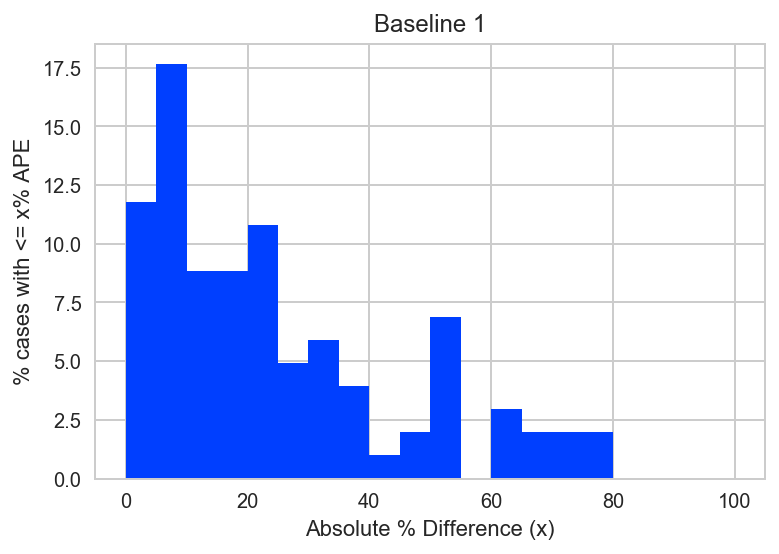

In [91]:
width = 5
hist_granular, bins_granular = np.histogram(df_test['om_ape'], bins=np.arange(0, 101, width))
hist_granular = hist_granular / len(df_test) * 100
f, ax = plt.subplots()
ax.bar(bins_granular[:-1], hist_granular, width=width, align='edge', label='Distribution')
ax.set_ylabel('% cases with <= x% APE')
ax.set_xlabel('Absolute % Difference (x)');
ax.grid(True)
ax.set_title('Baseline 1');

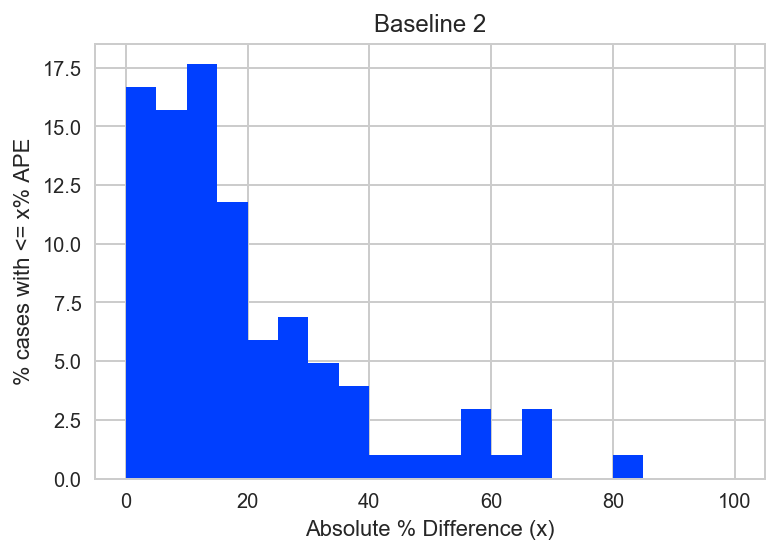

In [92]:
width = 5
hist_granular, bins_granular = np.histogram(df_test['rm_ape'], bins=np.arange(0, 101, width))
hist_granular = hist_granular / len(df_test) * 100
f, ax = plt.subplots()
ax.bar(bins_granular[:-1], hist_granular, width=width, align='edge', label='Distribution')
ax.set_ylabel('% cases with <= x% APE')
ax.set_xlabel('Absolute % Difference (x)');
ax.grid(True)
ax.set_title('Baseline 2');

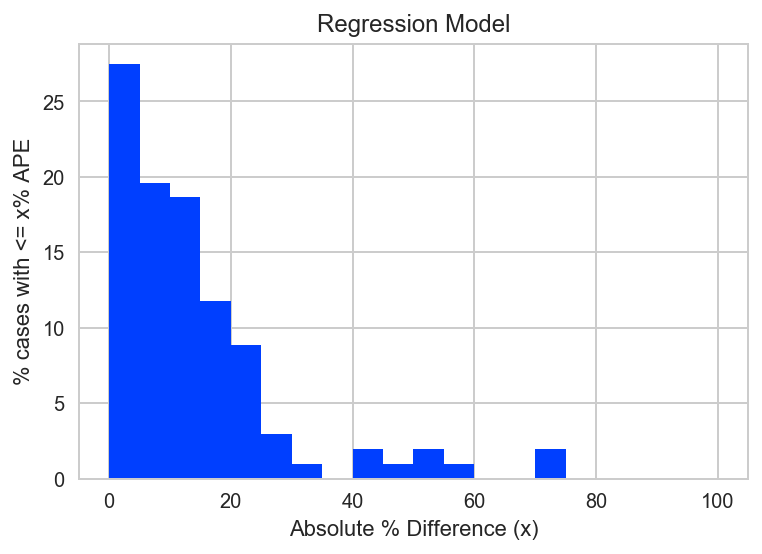

In [93]:
width = 5
hist_granular, bins_granular = np.histogram(df_test['md_ape'], bins=np.arange(0, 101, width))
hist_granular = hist_granular / len(df_test) * 100
f, ax = plt.subplots()
ax.bar(bins_granular[:-1], hist_granular, width=width, align='edge', label='Distribution')
ax.set_ylabel('% cases with <= x% APE')
ax.set_xlabel('Absolute % Difference (x)');
ax.set_ylim([])
ax.grid(True)
ax.set_title('Regression Model');

In [94]:
def print_perf(df, col_ae, col_ape, col_se, header):
    print(header)
    print('\tMean AE: $%.2f' % (df[col_ae].mean() * 1000))
    print('\tMedian AE: $%.2f' % (df[col_ae].median() * 1000))
    print('\tMean APE: %.2f%%' % (df[col_ape].mean()))
    print('\tMedian APE: %.2f%%' % (df[col_ape].median()))
    print('\tRMSE: $%.2f' % (math.sqrt(df[col_se].mean()) * 1000))
print_perf(df_test, 'om_ae', 'om_ape', 'om_se', 'Baseline 1 Performance')
print_perf(df_test, 'rm_ae', 'rm_ape', 'rm_se', '\nBaseline 2 Performance')
print_perf(df_test, 'md_ae', 'md_ape', 'md_se', '\nRegression Model Performance')

Baseline 1 Performance
	Mean AE: $6255.84
	Median AE: $4346.53
	Mean APE: 37.67%
	Median APE: 20.94%
	RMSE: $8662.88

Baseline 2 Performance
	Mean AE: $4651.28
	Median AE: $3073.93
	Mean APE: 27.87%
	Median APE: 14.96%
	RMSE: $6402.08

Regression Model Performance
	Mean AE: $3188.07
	Median AE: $2340.03
	Mean APE: 16.87%
	Median APE: 11.64%
	RMSE: $4932.84
